In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import img_as_float32

import starfish
import starfish.data
from starfish import ImageStack
from starfish.types import Indices

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
experiment = starfish.data.osmFISH(use_test_data=True)
stack = experiment['fov_000']['primary']

TypeError: resolve_path_or_url() got an unexpected keyword argument 'backend_config'

## Load pysmFISH results

The Field of view that we've used for the test data corresponds to Aldoc, imaged in round one, in position 33. We've also packaged the results from the osmFISH publication for this target to demonstrate that starfish is capable of recovering the same results. 

The below commands parse and load the results from this file. 

In [1]:
def load_results(pickle_file):
    with open(pickle_file, 'rb') as f:
        return pickle.load(f)

def get_benchmark_peaks(loaded_results, redo_flag=False):

    if not redo_flag:
        sp = pd.DataFrame(
            {
                'y':loaded_results['selected_peaks'][:,0],
                'x':loaded_results['selected_peaks'][:,1],
                'selected_peaks_int': loaded_results['selected_peaks_int'],
            }
        )
    else:
        p = peaks(loaded_results)
        coords = p[p.thr_array==loaded_results['selected_thr']].peaks_coords
        coords = coords.values[0]
        sp = pd.DataFrame({'x':coords[:,0], 'y':coords[:,1]})

    return sp

benchmark_results = load_results('./data/EXP-17-BP3597_hyb1_Aldoc_pos_33.pkl')
benchmark_peaks = get_benchmark_peaks(benchmark_results, redo_flag=False)

NameError: name 'pickle' is not defined

# Re-produce pysmFISH Results

## Filtering code

In [5]:
ghp = Filter.GaussianHighPass(sigma=(1,8,8), is_volume=True)
lp = Filter.Laplace(sigma=(0.2, 0.5, 0.5), is_volume=True)

stack_hp = ghp.run(stack, in_place=False)
stack_hp_lap = lp.run(stack_hp, in_place=False)

1it [00:00,  9.05it/s]
1it [00:00,  8.44it/s]


In [6]:
mp = stack_hp_lap.max_proj(Indices.Z)
for_vis = mp.xarray.sel({Indices.CH: 0}).squeeze()

100%|██████████| 1/1 [00:00<00:00, 121.95it/s]


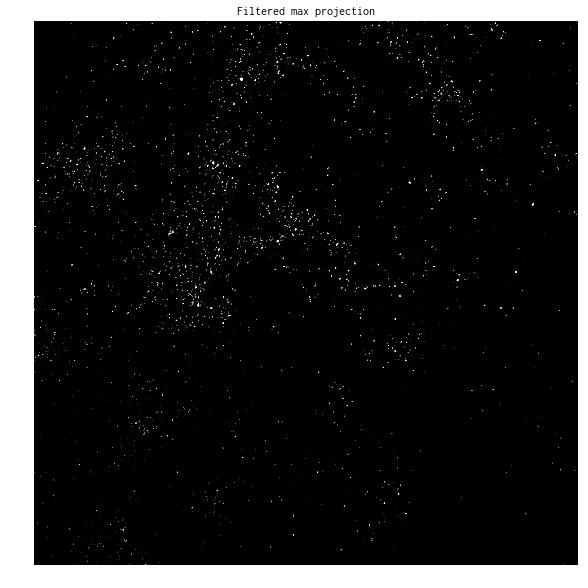

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(for_vis, cmap = 'gray', vmin=np.percentile(for_vis, 98), vmax=np.percentile(for_vis, 99.9))
plt.title('Filtered max projection')
plt.axis('off');

### Spot Finding

In [8]:
min_distance = 6
stringency = 0
min_obj_area = 6
max_obj_area = 600

# TODO this will go away once ImageStack.max_proj returns an ImageStack
# stack = ImageStack.from_numpy_array(np.expand_dims(np.expand_dims(np.expand_dims(mp, 0), 0), 0))

lmp = SpotFinder.LocalMaxPeakFinder(
    min_distance=min_distance,
    stringency=stringency,
    min_obj_area=min_obj_area,
    max_obj_area=max_obj_area
)
lmp_res = lmp.run(mp)

  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


 57%|█████▋    | 57/100 [00:25<00:19,  2.26it/s]

Stopping early at threshold=0.07317454672672533. Number of spots fell below: 3
computing final spots ...


### Spot finding QA

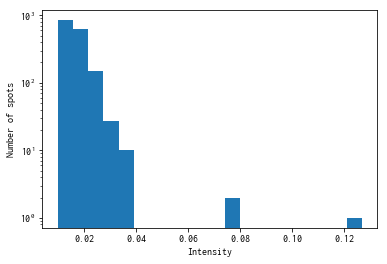

In [9]:
plt.hist(lmp_res.data[:,0,0], bins=20)
plt.yscale('log')
plt.xlabel('Intensity')
plt.ylabel('Number of spots');

100%|██████████| 1/1 [00:00<00:00, 124.01it/s]


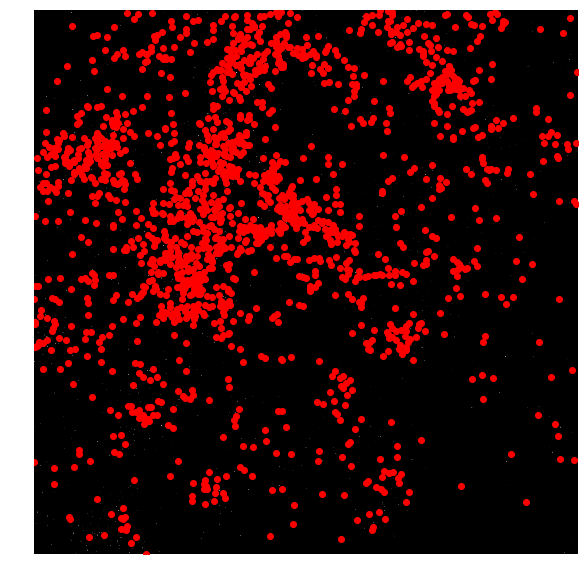

In [10]:
mp = stack_hp_lap.max_proj(Indices.Z)
mp = mp.sel({Indices.CH: 0, Indices.ROUND: 0}).xarray.squeeze()

plt.figure(figsize=(10,10))
plt.imshow(mp, cmap = 'gray', vmin=np.percentile(mp, 98), vmax=np.percentile(mp, 99.9))
plt.plot(lmp_res.x, lmp_res.y, 'or')
plt.axis('off');

## Compare to pySMFISH peak calls

Starfish finds 41 fewer spots


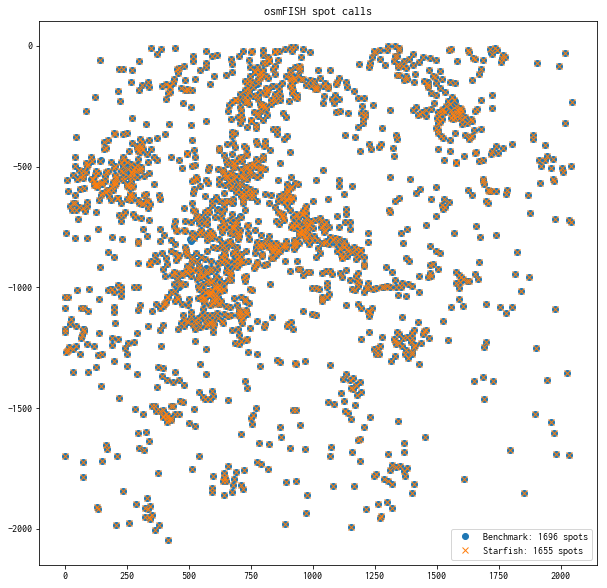

In [11]:
num_spots_simone = len(sp)
num_spots_starfish = len(lmp_res)

plt.figure(figsize=(10,10))
plt.plot(sp.x, -sp.y, 'o')
plt.plot(lmp_res.x, -lmp_res.y, 'x')

plt.legend(['Benchmark: {} spots'.format(num_spots_simone),
            'Starfish: {} spots'.format(num_spots_starfish)])
plt.title('osmFISH spot calls')

print("Starfish finds {} fewer spots".format(num_spots_simone-num_spots_starfish))